## A. INSTALL MODULE & PREPARE DATA

In [12]:
from __future__ import print_function
%matplotlib inline
import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os
import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [3]:
sagemaker_session = sagemaker.Session()

In [17]:
s3_bucket = "hos09a"  # Replace with an existing bucket if needed
s3_prefix = "deepar-electricity-demo-notebook"  # Prefix used for all data stored within the bucket

In [20]:
role = sagemaker.get_execution_role()  # IAM role to use by SageMaker
print(role)

arn:aws:iam::850995577816:role/ecsInstanceRole


In [21]:
region = sagemaker_session.boto_region_name
print(region)

us-east-1


In [22]:
s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

In [31]:
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region)

In [40]:
# DATA_HOST = "sagemaker-sample-files"
# DATA_PATH = "datasets/timeseries/uci_electricity/"
# ARCHIVE_NAME = "LD2011_2014.txt.zip"
DATA_HOST = "hos09a"
DATA_PATH = ""
ARCHIVE_NAME = "LD2011_2014.zip"
# FILE_NAME = ARCHIVE_NAME[:-4]
FILE_NAME = "LD2011_2014.txt"  # Update to the correct file name

In [41]:
s3_client = boto3.client("s3")

if not os.path.isfile(FILE_NAME):
    print("Downloading dataset (258MB), can take a few minutes depending on your connection")
    s3_client.download_file(DATA_HOST, DATA_PATH + ARCHIVE_NAME, ARCHIVE_NAME)

    print("\nExtracting data archive")
    zip_ref = zipfile.ZipFile(ARCHIVE_NAME, "r")
    zip_ref.extractall("./")
    zip_ref.close()
else:
    print("File found, skipping download")


Extracting data archive


In [42]:
data = pd.read_csv(FILE_NAME, sep=";", index_col=0, parse_dates=True, decimal=",")
num_timeseries = data.shape[1]
data_kw = data.resample("2H").sum() / 8
timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:, i], trim="f"))

## B. TRAIN & TEST SPLITS

In [43]:
# We use 2-hour frequency for the time series
freq = "2H"

# We predict for 7 days
prediction_length = 7 * 12

# We also use 7 days as context length, this is the number of state updates accomplished before making predictions
context_length = 7 * 12

In [44]:
start_dataset = pd.Timestamp("2014-01-01 00:00:00")
end_training = pd.Timestamp("2014-09-01 00:00:00")

In [45]:
training_data = [
    {
        "start": str(start_dataset),
        "target": ts[
            start_dataset : end_training - timedelta(days=1)
        ].tolist(),  # We use -1 because pandas indexing includes the upper bound
    }
    for ts in timeseries
]
print(len(training_data))

370


In [46]:
num_test_windows = 4

test_data = [
    {
        "start": str(start_dataset),
        "target": ts[
            start_dataset : end_training + timedelta(days=k * prediction_length)
        ].tolist(),
    }
    for k in range(1, num_test_windows + 1)
    for ts in timeseries
]
print(len(test_data)) 

1480


In [47]:
def write_dicts_to_file(path, data):
    with open(path, "wb") as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode("utf-8"))

In [48]:
# Writing to files
%time
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

CPU times: user 0 ns, sys: 3 μs, total: 3 μs
Wall time: 5.72 μs


In [49]:
s3 = boto3.resource("s3")

def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith("s3://")
    split = s3_path.split("/")
    bucket = split[2]
    path = "/".join(split[3:])
    buk = s3.Bucket(bucket)

    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print(f"File {s3_path} already exists. Set override to upload anyway.")
            return
    else:
        print("Overwriting existing file")

    with open(local_file, "rb") as data:
        print(f"Uploading file to {s3_path}")
        buk.put_object(Key=path, Body=data)

In [50]:
%time
copy_to_s3("train.json", s3_data_path + "/train/train.json")
copy_to_s3("test.json", s3_data_path + "/test/test.json")

CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 6.91 μs
Overwriting existing file
Uploading file to s3://hos09a/deepar-electricity-demo-notebook/data/train/train.json
Overwriting existing file
Uploading file to s3://hos09a/deepar-electricity-demo-notebook/data/test/test.json


In [51]:
s3_sample = s3.Object(s3_bucket, s3_prefix + "/data/train/train.json").get()["Body"].read()
StringVariable = s3_sample.decode("UTF-8", "ignore")
lines = StringVariable.split("\n")
print(lines[0][:100] + "...")

{"start": "2014-01-01 00:00:00", "target": [2.696700507614215, 2.85532994923858, 2.53807106598985, 3...


## C. TRAIN NTHE MODEL

In [52]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    instance_count=1,
    instance_type="ml.c4.2xlarge",
    base_job_name="deepar-electricity-demo",
    output_path=s3_output_path,
)

In [53]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
}

In [54]:
estimator.set_hyperparameters(**hyperparameters)

In [55]:
# Fit the model
%time
data_channels = {
    "train": "{}/train/".format(s3_data_path),
    "test": "{}/test/".format(s3_data_path),
}
estimator.fit(inputs=data_channels, wait=True)

INFO:sagemaker:Creating training-job with name: deepar-electricity-demo-2024-12-06-23-56-23-241


CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 5.96 μs
2024-12-06 23:56:24 Starting - Starting the training job...
2024-12-06 23:56:39 Starting - Preparing the instances for training...
2024-12-06 23:57:19 Downloading - Downloading the training image..................
2024-12-07 00:00:01 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[12/07/2024 00:00:16 INFO 140571367085888] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patie

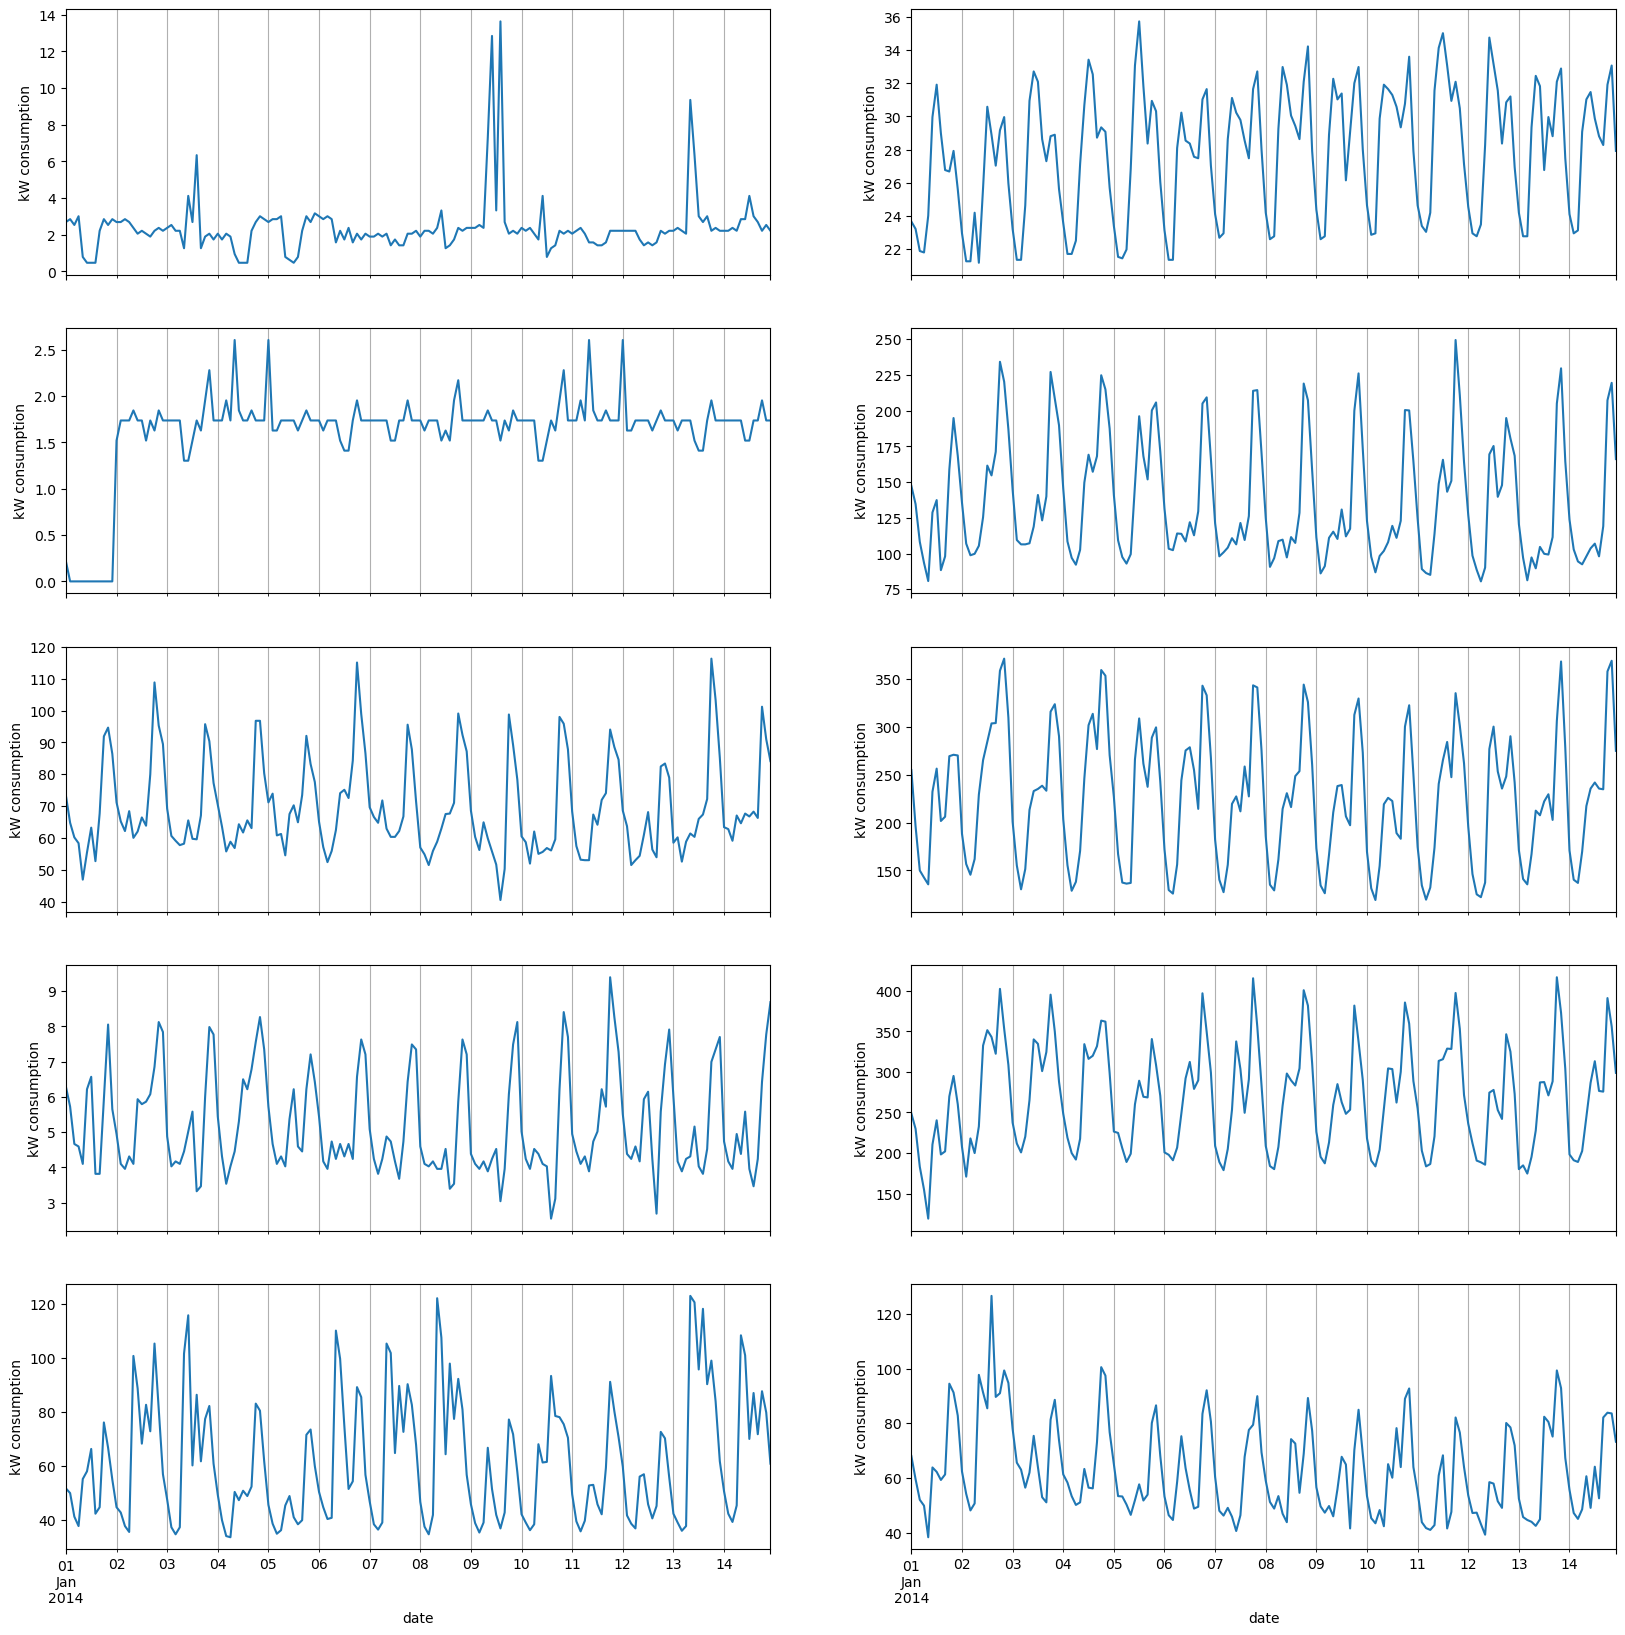

In [56]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()

for i in range(0, 10):
    timeseries[i].loc["2014-01-01":"2014-01-14"].plot(ax=axx[i])
    axx[i].set_xlabel("date")
    axx[i].set_ylabel("kW consumption")
    axx[i].grid(which="minor", axis="x")